# Homework 1 - Part B
You are interviewing with Google’s ad team and one of their tasks is predicting the Click Through Rate (CTR) of ads they place on web or mobile properties. Code up a model that predicts the CTR based on Logistic Regression.

---

### Part 1 - Data Cleanup

To start, these are all the libraries I will be using to construct and run a logistic regression model, and display results:

In [3]:
# For fast processing of tensors
import torch
import torch.linalg

# Other numerical processing
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Data importing
import pandas as pd

This Python notebook assumes that the `test.gz` and `train.gz` files from the click through rate prediction data set can be found in the `./data` folder.

I start by using the `pandas` library to load data from the `csv` files (compressed with the gzip format) into `pandas` Dataframes which I can perform some basic data cleaning on. Below I list out the columns of the data just to get a rough overview. I was hoping the anonymized columns would be named in the dataset but they are still C14 - C21 so I will definitely have to investigate them.

I'm starting with the test set and only part of the train set as currently the full train set is too large for me to load without crashing my environment.

In [4]:
# Load the train and test sets
test_data = pd.read_csv("./data/test.csv")
partial_train_data = pd.read_csv('./data/train.gz', compression="gzip", nrows=1e5)

# List the columns
partial_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                100000 non-null  float64
 1   click             100000 non-null  int64  
 2   hour              100000 non-null  int64  
 3   C1                100000 non-null  int64  
 4   banner_pos        100000 non-null  int64  
 5   site_id           100000 non-null  object 
 6   site_domain       100000 non-null  object 
 7   site_category     100000 non-null  object 
 8   app_id            100000 non-null  object 
 9   app_domain        100000 non-null  object 
 10  app_category      100000 non-null  object 
 11  device_id         100000 non-null  object 
 12  device_ip         100000 non-null  object 
 13  device_model      100000 non-null  object 
 14  device_type       100000 non-null  int64  
 15  device_conn_type  100000 non-null  int64  
 16  C14               100

I'm going to investigate the non-numeric columns and see if any of them are worth encoding to a numeric format to be able to use in my logistic regressor.

In [5]:
partial_train_data.select_dtypes(include=["object"]).nunique()

site_id            893
site_domain        780
site_category       16
app_id             704
app_domain          55
app_category        19
device_id         7202
device_ip        40376
device_model      2473
dtype: int64

From this `site_category` and `app_category` look the most reasonable to encode, but I'm not entirely sure of this as I'm not working with a more full data set, so let's take a look at these features.

In [6]:
partial_train_data.app_category.value_counts()

app_category
07d7df22    78828
0f2161f8    14971
f95efa07     2895
8ded1f7a     1347
cef3e649     1309
75d80bbe      171
4ce2e9fc      130
d1327cf5      129
09481d60       50
fc6fa53d       41
dc97ec06       40
a3c42688       32
0f9a328c       18
879c24eb       16
a86a3e89        8
7113d72a        7
a7fd01ec        4
4681bb9d        2
8df2e842        2
Name: count, dtype: int64

In [7]:
partial_train_data.site_category.value_counts()

site_category
28905ebd    37696
50e219e0    25399
f028772b    19760
3e814130    12480
76b2941d     1843
335d28a8     1329
0569f928      675
72722551      314
f66779e6      279
75fa27f6      146
c0dd3be3       55
bcf865d9       13
a818d37a        7
42a36e14        2
110ab22d        1
e787de0e        1
Name: count, dtype: int64

The problem I run into with this feature is I have no indication or key telling me how many site or app categories there are, so I'm left with a bunch of strings of, presumably hexadecimal values (maybe bit strings of flags, in which case there seem to be a lot of possible categories?) that I'm not sure I'll be able to map reliable if my test set doesn't have the same complete set of categories. I'll leave it out for now and try to throw it back in if my model struggles without it.

In the meanwhile I will plot all the numeric categories to find any possible patterns I can work with.

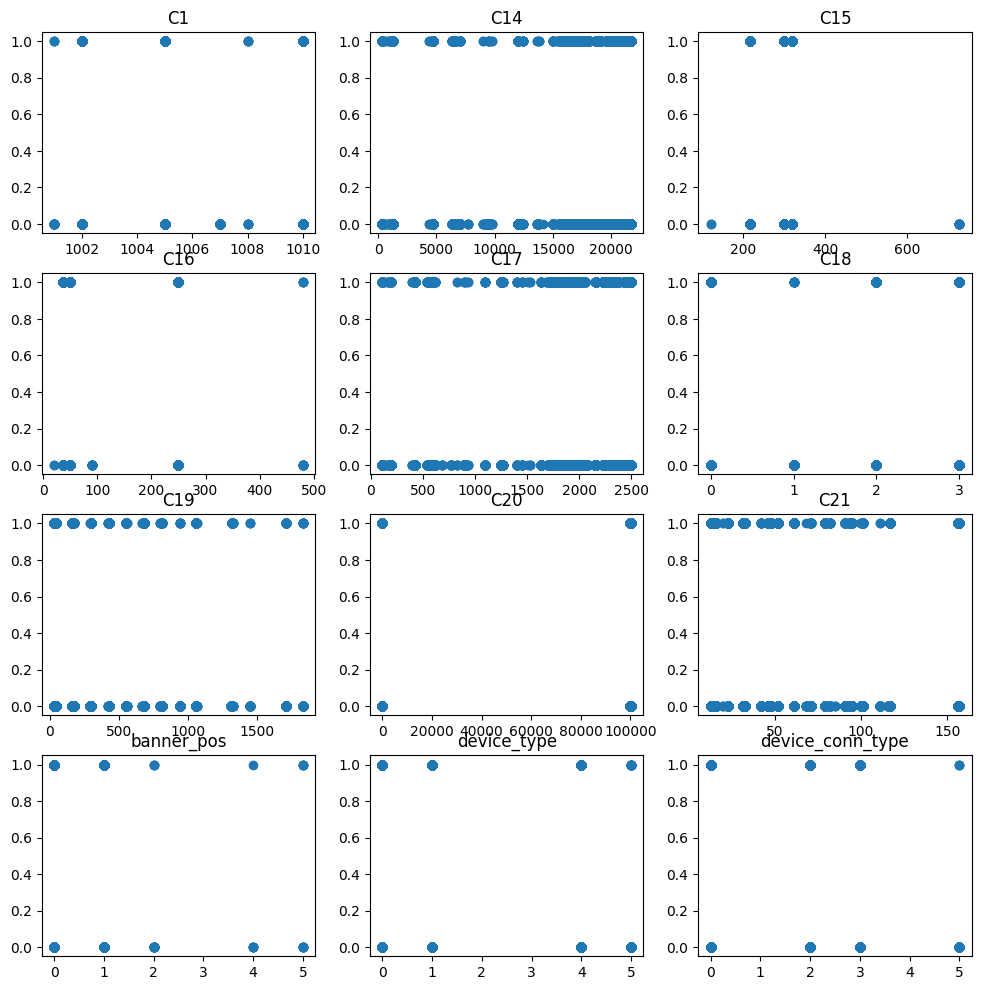

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Used to generate a single labeled plot
def gen_plot(axis, category, data):
    axis.scatter(data[category], data.click)
    axis.set_title(category)

# The layout of plots
cols_organized = [["C1", "C14", "C15"], 
                  ["C16", "C17", "C18"], 
                  ["C19", "C20", "C21"], 
                  ["banner_pos", "device_type", "device_conn_type"]]

# Iterate and plot all my plots
for row in range(4):
    for col in range(3):
        gen_plot(axes[row][col], cols_organized[row][col], partial_train_data)

No particular patterns emerge just from plotting, although the `1` class appears to be fairly clustered in `C15` so I may use this in initial testing of my logistic regressor.

I will also create these plots to investigate the timestamp data. I'm specifically more interested in the month, day, and hour data as things like the holiday season may impact the click through rate of ads.

Text(0.5, 1.0, 'Month')

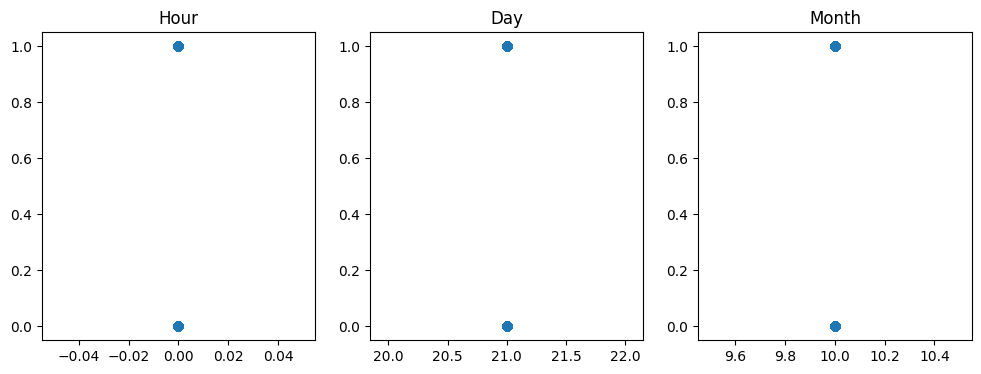

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Since timestamps are formatted as YYMMDDHH I will extract each component using modulus
hour = partial_train_data.hour % 100
day = (partial_train_data.hour - hour) // 100 % 100
month = (partial_train_data.hour - day - hour) // 10000 % 100

# And plot
axes[0].scatter(hour, partial_train_data.click)
axes[0].set_title("Hour")
axes[1].scatter(day, partial_train_data.click)
axes[1].set_title("Day")
axes[2].scatter(month, partial_train_data.click)
axes[2].set_title("Month")

Analyzing these data points is rather difficult as I do not have the full train set loaded so I do not have all 10 days in the train set to discern any patterns here. Since data is ordered chronologically and I only extracted a relatively small portion of the full data set, I can definitely see why I only have one x value here on each plot.

That being said, only the hour feature is particularly interesting to me between hour, month, and day since the train set is data from over 10 days so I won't get much variation from the month and day features anyway. As for the hour feature, I'm curious to see what proportion of data has a `click` class of `1` or `0`. This should give me a rough idea if there's any correlation between the `click` class and the hour though I recognize I may not be working with every data point with an hour of `0` so I don't know how reflective this will be.

In [10]:
# Since the hour is 0 for the entire portion of the dataset I'm looking at this should give me some rough idea
partial_train_data.click.value_counts()

click
0    82510
1    17490
Name: count, dtype: int64

This is at least indicative that in my final model it may be worth extracting the hour data. Now I will write my preprocessing function to extract the numerical categorical variables, and extract only the hour from the timestamp feature.

This function will also clean NaNs and NULLs.

In [11]:
def preprocess(df):
    # Extract columns I want
    df = df[['id', 'click', 'hour', 'C1', 'banner_pos', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]

    # Remove None and NaN
    df = df.dropna()

    # Extract hour data
    df.hour = df.hour % 100
    
    return df

Here's roughly what the cleaned dataset looks like:

In [12]:
partial_train_data = preprocess(partial_train_data)
partial_train_data.head(5)

,id,click,hour,C1,banner_pos,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,0,1005,0,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,0,1005,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,0,1005,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,0,1005,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,0,1005,1,18993,320,50,2161,0,35,-1,157


I did some testing and unfortunately I still can't load the entire dataset, so when I perform **Stochastic Gradient Descent** I'll have to decide on a batch size that my environment can handle, and then work with certain chunks at a time. For now let's figure out the number of rows in the training data.

In [13]:
# Load the train data
CHUNK_SIZE = 10 ** 6
row_count = 0

with pd.read_csv("./data/train.gz", compression="gzip", chunksize=CHUNK_SIZE) as reader:
    for chunk in reader:
        row_count += len(chunk)

# Preprocess the test data
row_count

40428967

To create and test the logistic regressor, I will for now use the first $1000000$ rows of the train set (10x more than what I've been working with so far), and I will probably only use the `C15` column and the `hour` column. (I plan on using at least two columns since once my model is complete I should be able to generalize to more features as long as it works for at least two columns).

### Part 2 - Logistic Regression and SGD Model

The **Sigmoid** function is defined as follows:
$$
\sigma(\alpha)=\frac{1}{1+\text{exp}(-\alpha)}
$$
To make a prediction with this function, we compute the following:
$$
\sigma(\textbf{w}^{T} \textbf{x})
$$
Where $\textbf{w}$ represents the weights of the activation we tune using SGD, and $\textbf{x}$ represents a feature vector. The sigmoid function itself is implemented by the PyTorch library in `torch.sigmoid`

Before we define the prediction function I should clarify that I am including the **Bias** term in $\textbf{w}$ so when I convert a row of selected features from the train set into an input vector $\textbf{x}$, for the bias term to work correctly I would have to include an $x_{0}=1$ component in the input vector.

We can define the "predict" function as follows:

In [ ]:
'''
Make a prediction using the sigmoid activation given 
    w   - The weight vector w
    b   - The bias
    x   - The feature vector
'''
def predict(w, x):
    theta = torch.dot(w, x)
    return torch.sigmoid(theta)

Next we need to define not just the loss function, but specifically the gradient of the loss function. For a binary classifier defined by a single sigmoid activation, the gradient of the binary cross entropy loss function is:
$$
\nabla_{w}L=\sum_{i=1}^{m}(y_{i}-y_{i})\textbf{x}_{i}
$$
If we're using stochastic gradient descent we will perform a summation over a mini batch as opposed to the entire $m$, thus:
$$
\nabla_{w}L=\sum_{i=1}^{m_{b}}(y_{i}-y_{i})\textbf{x}_{i}
$$
where we define $m_{b}$ to be some mini batch derived from the entire train set.

Since for testing purposes we won't yet be working with the entire data set (which will require some extra code to generate minibatches from) I will create a generic function that will compute this gradient over some given "batch" `m`.

To best utilize PyTorch's fast matrix operations and computational capabilities, here's how I will compute the gradient. I will define $M_{b}$ to be a tensor such that every row of the tensor correspond to a row in the train set with an extra column of $1$ for the bias term. For example suppose my minibatch only has 2 rows and I'm only using two features:
$$
M_{b}=\begin{bmatrix}
x_{12} & x_{11} & x_{10}\\
x_{22} & x_{21} & x_{20}
\end{bmatrix}
$$
In this example, $x_{ij}$ is defined where $i$ is the row number and $j$ is the component of the vector/feature number ($j=0$ refers to the component that will become the bias term so $x_{i0}$ will always be $1$).

I will use this matrix and the weight vector $\mathbf{w}$ to compute a vector of $\hat{y}$ where every component of this vector corresponds to my prediction from the corresponding row in $M_{b}$. To do this, I will compute $M_{b}\mathbf{w}$ and apply the $\sigma$ function element wise to the result, giving me a $\hat{\mathbf{y}}$ vector.

This I can subtract from a vector of $y$ created from the data set by converting the `click` column into a vector. This subtraction will be done elementwise. The resultant vector, I'll call $\mathbf{d}$ can then be multiplied by $M_{b}$ element wise to compute each vector in the summation that results in the final gradient. 

To perform the summation, I can use `torch.sum` with `dim=1` which should result in my final gradient.

To write this function in Python, my Python function will take a dataframe with the `click` feature and any other features that will be used to generate $M_{b}$ (I will pop off the `click` feature and the `id` feature). This way my function can be generalized to any number of numeric features.

In [101]:
'''
m_b - The dataframe with only the features we want to work with and the click feature
w - The current weights with the bias
'''
def logistic_gradient(m_b, w):
    # Create y_vec
    y_vec = torch.tensor(m_b.click.values)
    
    # Create the M_b tensor/matrix
    M_b = torch.tensor(m_b.drop('click', axis=1).values)
    bias_col = torch.ones(M_b.shape[0], 1)
    M_b = torch.cat((M_b, bias_col), dim=1)

    # Compute the y_hat vector
    y_hat_vec = torch.matmul(M_b, w)
    y_hat_vec = torch.sigmoid(y_hat_vec)

    # Compute the difference
    d = y_hat_vec.squeeze() - y_vec

    # Multiply by M_b
    grad = d.view(M_b.shape[0], 1) * M_b

    # Compute the summation
    grad = grad.sum(dim=0)

    return grad

In [102]:
a = logistic_gradient(partial_train_data[['click', 'C15', 'hour']], torch.ones(3, 1))
print(a)

tensor([26289856.,        0.,    82510.])
